# Visualize Eperiment Results - Imputation Performance

This notebook should answer the questions: *Which imputer works best to re-construct missing values?*

## Notebook Structure 

* Application Scenario 1 - Imputation Performance 
   * Categorical  Columns (Classification)
   * Numerical Columns (Regression)
   * Heterogenous Columns (Classification and Regression Combined)

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import seaborn as sns

from pathlib import Path
from data_imputation_paper.experiment import read_experiment, read_csv_files

%matplotlib inline

%load_ext autoreload
%autoreload 2

## Settings

In [2]:
sns.set(style="whitegrid")
sns.set_context('paper', font_scale=1.5)
mpl.rcParams['lines.linewidth'] = '2'

In [3]:
EXPERIMENT_PATH = Path("../data/experiments/cluster4/fully_observed/")
FIGURES_PATH = Path("../reports/figures/fully_observed/")

CLF_METRIC = "F1_macro"
REG_METRIC = "RMSE"

IMPUTE_RESULT_TYPE = "impute_performance_mean"

## Import the data

In [4]:
read_experiment(EXPERIMENT_PATH).head()

,experiment,imputer,task,missing_type,missing_fraction,strategy,file_or_dir,detail_file,path
0,fully_observed,AutoKerasImputer,40922,MCAR,0.01,single_all,impute_performance_mean_gyro_y.csv,,../data/experiments/cluster4/fully_observed/Au...
1,fully_observed,AutoKerasImputer,40922,MCAR,0.01,single_all,downstream_performance_mean_gyro_y.csv,,../data/experiments/cluster4/fully_observed/Au...
2,fully_observed,AutoKerasImputer,40922,MCAR,0.01,single_all,downstream_performance_std_gyro_y.csv,,../data/experiments/cluster4/fully_observed/Au...
3,fully_observed,AutoKerasImputer,40922,MCAR,0.01,single_all,impute_performance_std_gyro_y.csv,,../data/experiments/cluster4/fully_observed/Au...
4,fully_observed,AutoKerasImputer,40922,MCAR,0.01,single_all,gyro_y,impute_performance_rep_2.csv,../data/experiments/cluster4/fully_observed/Au...


In [5]:
%%time

results = read_csv_files(read_experiment(EXPERIMENT_PATH), read_details=False)
results.head()

CPU times: user 1min 11s, sys: 1.74 s, total: 1min 13s
Wall time: 1min 13s


,experiment,imputer,task,missing_type,missing_fraction,strategy,column,result_type,metric,train,test,baseline,corrupted,imputed
0,fully_observed,AutoKerasImputer,40922,MCAR,0.01,single_all,gyro_y,impute_performance_std,MAE,0.490070,0.564987,NaN,NaN,NaN
1,fully_observed,AutoKerasImputer,40922,MCAR,0.01,single_all,gyro_y,impute_performance_std,MSE,9.137480,10.071950,NaN,NaN,NaN
2,fully_observed,AutoKerasImputer,40922,MCAR,0.01,single_all,gyro_y,impute_performance_std,RMSE,0.612642,0.631353,NaN,NaN,NaN
3,fully_observed,AutoKerasImputer,40922,MCAR,0.30,single_all,gyro_y,impute_performance_std,MAE,0.125774,0.180896,NaN,NaN,NaN
4,fully_observed,AutoKerasImputer,40922,MCAR,0.30,single_all,gyro_y,impute_performance_std,MSE,2.105718,0.627795,NaN,NaN,NaN


In [6]:
impute_results = results[
    (results["result_type"] == IMPUTE_RESULT_TYPE) & 
    (results["metric"].isin([CLF_METRIC, REG_METRIC]))
]
assert len(results["strategy"].unique()) == 1
impute_results.drop(["experiment", "train", "strategy", "baseline", "corrupted", "imputed"], axis=1, inplace=True) 
impute_results = impute_results.rename(
    {
        "imputer": "Imputer",
        "task": "Task",
        "missing_type": "Missing Type",
        "missing_fraction": "Missing Fraction",
        "column": "Column",
        "test": "Imputation"
    },
    axis = 1
)
impute_results.head()

,Imputer,Task,Missing Type,Missing Fraction,Column,result_type,metric,Imputation
14615,AutoKerasImputer,40922,MCAR,0.01,gyro_y,impute_performance_mean,RMSE,7.997631
14618,AutoKerasImputer,40922,MCAR,0.30,gyro_y,impute_performance_mean,RMSE,8.726117
14621,AutoKerasImputer,40922,MCAR,0.50,gyro_y,impute_performance_mean,RMSE,9.551563
14624,AutoKerasImputer,40922,MCAR,0.10,gyro_y,impute_performance_mean,RMSE,9.039884
14627,AutoKerasImputer,40922,MNAR,0.01,gyro_y,impute_performance_mean,RMSE,4.305710


## Compute Imputer Ranking

In [7]:
EXPERIMENTAL_CONDITIONS = ["Task", "Missing Type", "Missing Fraction", "Column", "result_type", "metric"]

clf_row_idx = results["metric"] == CLF_METRIC
reg_row_idx = results["metric"] == REG_METRIC

In [8]:
impute_results.loc[clf_row_idx, "Imputation Rank"] = impute_results[clf_row_idx].groupby(EXPERIMENTAL_CONDITIONS).rank(ascending=False, na_option="bottom", method="min")["Imputation"]
impute_results.loc[reg_row_idx, "Imputation Rank"] = impute_results[reg_row_idx].groupby(EXPERIMENTAL_CONDITIONS).rank(ascending=True, na_option="bottom", method="min")["Imputation"]
impute_results

,Imputer,Task,Missing Type,Missing Fraction,Column,result_type,metric,Imputation,Imputation Rank
14615,AutoKerasImputer,40922,MCAR,0.01,gyro_y,impute_performance_mean,RMSE,7.997631,1.0
14618,AutoKerasImputer,40922,MCAR,0.30,gyro_y,impute_performance_mean,RMSE,8.726117,1.0
14621,AutoKerasImputer,40922,MCAR,0.50,gyro_y,impute_performance_mean,RMSE,9.551563,1.0
14624,AutoKerasImputer,40922,MCAR,0.10,gyro_y,impute_performance_mean,RMSE,9.039884,1.0
14627,AutoKerasImputer,40922,MNAR,0.01,gyro_y,impute_performance_mean,RMSE,4.305710,1.0
...,...,...,...,...,...,...,...,...,...
29213,GAINImputer,1220,MCAR,0.10,keyword_id,impute_performance_mean,RMSE,NaN,6.0
29216,GAINImputer,1220,MNAR,0.01,keyword_id,impute_performance_mean,RMSE,NaN,6.0
29219,GAINImputer,1220,MNAR,0.30,keyword_id,impute_performance_mean,RMSE,NaN,6.0
29222,GAINImputer,1220,MNAR,0.50,keyword_id,impute_performance_mean,RMSE,NaN,5.0


### Check if the scores/ranks are normally distributed

Otherwise it might not make sense to show the standard deviations / confidence intervals it the plots below.

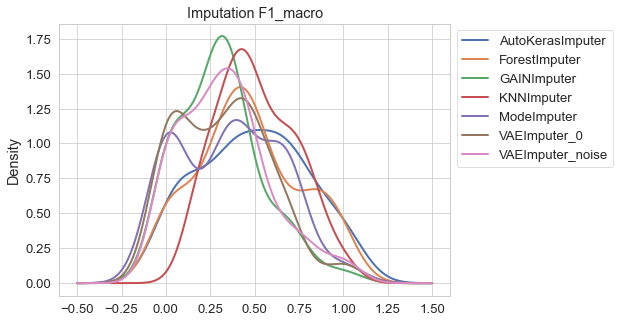

In [9]:
kde_data = impute_results.loc[clf_row_idx, ["Imputer", "Imputation"]]
kde_data = kde_data.pivot(columns="Imputer", values="Imputation")

kde_data.plot(kind="kde", title=f"Imputation {CLF_METRIC}", figsize=(7,5))
plt.legend(bbox_to_anchor=(1,1), loc="upper left") #place legend in top right corner

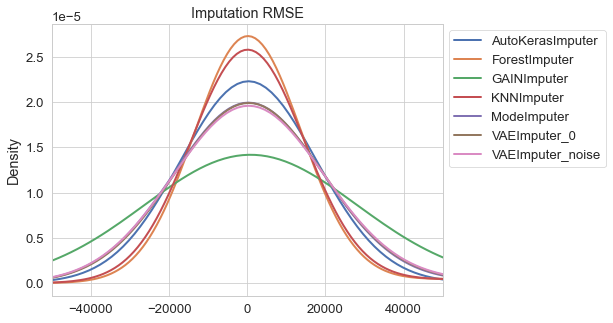

In [10]:
kde_data = impute_results.loc[reg_row_idx, ["Imputer", "Imputation"]]
kde_data = kde_data.pivot(columns="Imputer", values="Imputation")

kde_data.plot(kind="kde", title=f"Imputation {REG_METRIC}", figsize=(7,5), xlim=(-50000, 50000))
plt.legend(bbox_to_anchor=(1,1), loc="upper left") #place legend in top right corner

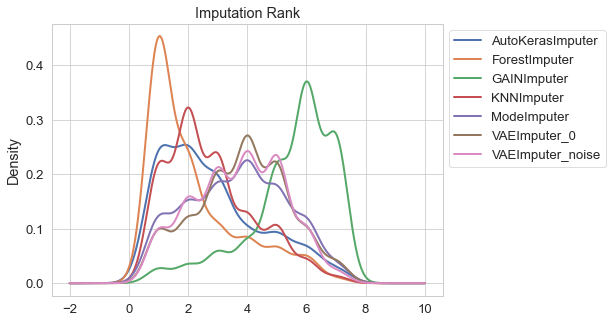

In [11]:
kde_data = impute_results[["Imputer", "Imputation Rank"]]
kde_data = kde_data.pivot(columns="Imputer", values="Imputation Rank")

kde_data.plot(kind="kde", title="Imputation Rank", figsize=(7,5))
plt.legend(bbox_to_anchor=(1,1), loc="upper left") #place legend in top right corner

### Check if results are complete

The bars in the following plot should have the same height.

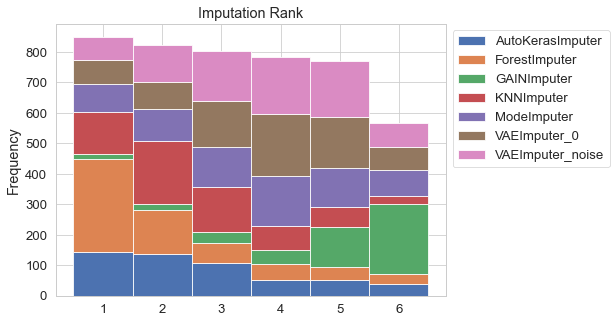

In [12]:
row_idx = impute_results["result_type"] == IMPUTE_RESULT_TYPE
check_data = impute_results.loc[row_idx, ["Imputer", "Imputation Rank"]]
check_data = check_data.pivot(columns="Imputer", values="Imputation Rank")

check_data.plot(kind="hist", title="Imputation Rank", figsize=(7,5), stacked=True, bins=np.linspace(0.5, 6.5, 7))
plt.legend(bbox_to_anchor=(1,1), loc="upper left") #place legend in top right corner

## Plotting Functions

In [17]:
def plot_metric_vs_missing_fraction(data, result_type, metric_names, y, ylabel, export_path, figure_name):
    row_idx = (data["result_type"] == result_type) & (data["metric"].isin(metric_names))
    plot_data = data[row_idx]
    
    plt.figure(figsize=(10,7))
    ax = sns.lineplot(
        data=plot_data, 
        x="Missing Fraction", 
        y=y, 
        hue="Imputer", 
        style="Imputer",
        ci=66
    )
    ax.set(ylabel=ylabel)
    ax.set_xticks(sorted(plot_data["Missing Fraction"].unique()))
    
    plt.legend(bbox_to_anchor=(1,1), loc="upper left") #place legend in top right corner 
    
    Path(export_path/result_type).mkdir(parents=True, exist_ok=True)    
    plt.savefig(export_path/result_type/f"{figure_name}.svg")

## Application Scenario 1 - Imputation Performance

### 1.1) Categorical Columns (Classification)

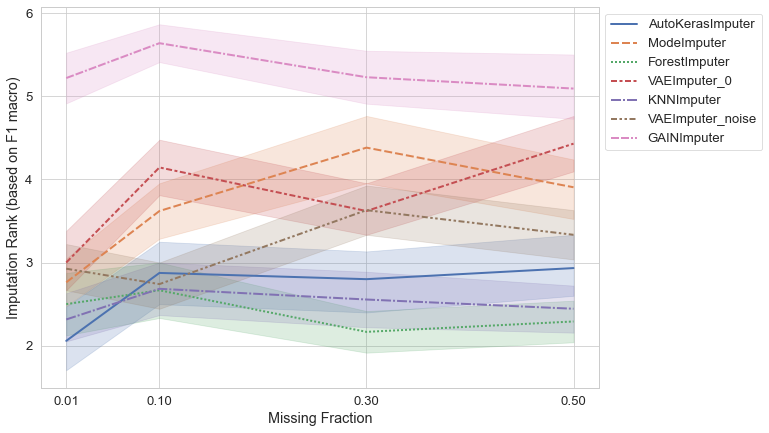

In [18]:
plot_metric_vs_missing_fraction(
    data = impute_results, 
    result_type = IMPUTE_RESULT_TYPE,
    metric_names = [CLF_METRIC], 
    y = "Imputation Rank",
    ylabel = f"Imputation Rank (based on {CLF_METRIC.replace('_', ' ')})",
    export_path = FIGURES_PATH,
    figure_name = "categorical_rank"
)

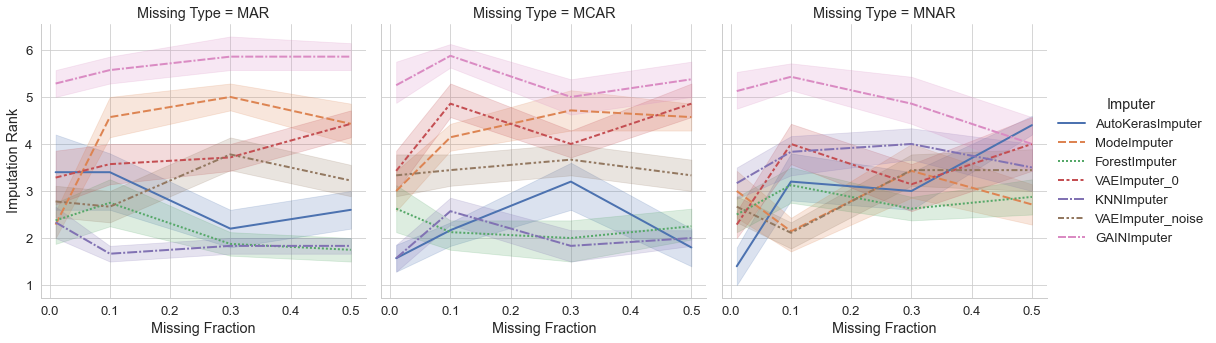

In [19]:
row_idx = (results["result_type"] == IMPUTE_RESULT_TYPE) & (results["metric"].isin([CLF_METRIC]))
plot_data = impute_results[row_idx]

ax = sns.relplot(
    data=plot_data, 
    x="Missing Fraction", 
    y="Imputation Rank", 
    hue="Imputer", 
    style="Imputer", 
    col="Missing Type",
    kind="line",
    ci=50
)
#ax.set_xticks(sorted(results["Missing Fraction"].unique()))
plt.gcf().subplots_adjust(bottom=0.15, left=0.05) # avoid x/ylabel cutoff in SVG export
plt.savefig(FIGURES_PATH/IMPUTE_RESULT_TYPE/"relplot.svg")

### 1.2) Numerical Columns (Regression)

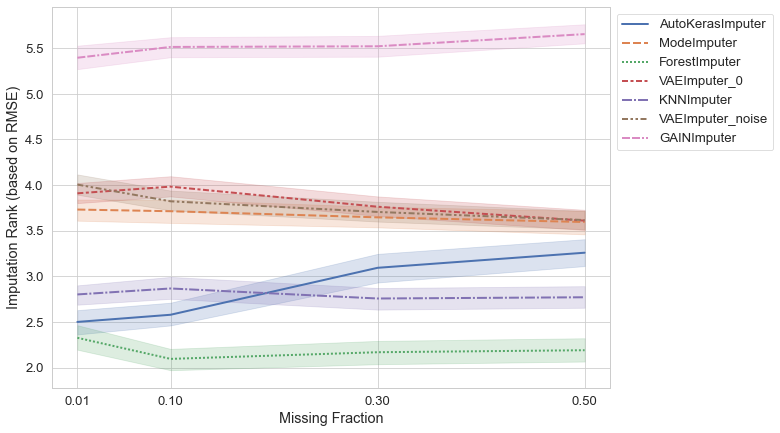

In [20]:
plot_metric_vs_missing_fraction(
    data = impute_results, 
    result_type = IMPUTE_RESULT_TYPE,
    metric_names = [REG_METRIC], 
    y = "Imputation Rank",
    ylabel = f"Imputation Rank (based on {REG_METRIC})",
    export_path = FIGURES_PATH,
    figure_name = "numerical_rank"
)

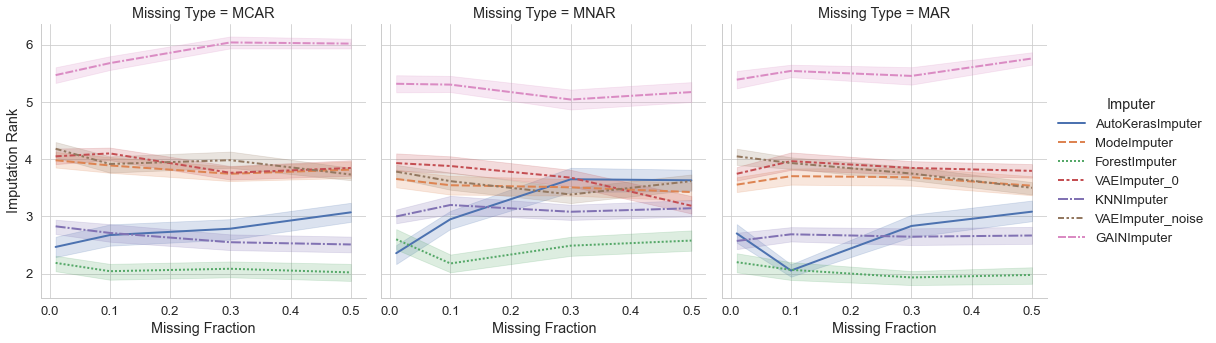

In [21]:
row_idx = (results["result_type"] == IMPUTE_RESULT_TYPE) & (results["metric"].isin([REG_METRIC]))
plot_data = impute_results[row_idx]

ax = sns.relplot(
    data=plot_data, 
    x="Missing Fraction", 
    y="Imputation Rank", 
    hue="Imputer", 
    style="Imputer", 
    col="Missing Type",
    kind="line",
    ci=50
)
#ax.set_xticks(sorted(results["Missing Fraction"].unique()))
plt.gcf().subplots_adjust(bottom=0.15, left=0.05) # avoid x/ylabel cutoff in SVG export
plt.savefig(FIGURES_PATH/IMPUTE_RESULT_TYPE/"relplot.svg")

### 1.3) Heterogenous Columns (Classification and Regression Combined)

In [22]:
row_idx = (results["result_type"] == IMPUTE_RESULT_TYPE) & (results["metric"].isin([CLF_METRIC, REG_METRIC]))
check_data = results[row_idx]
check_data.groupby(["metric"]).size()

metric
F1_macro     598
RMSE        4273
dtype: int64

The data is not equally distributed between categorical and numerical imputation tasks, so simply averaging the ranks, as done in the plots below, could be misleading.

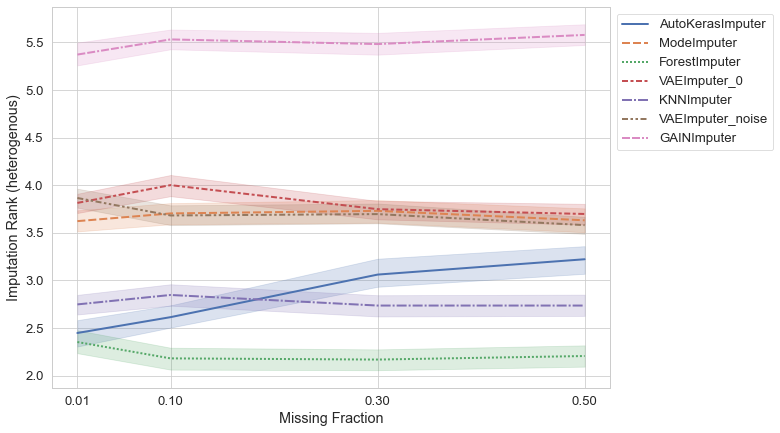

In [23]:
plot_metric_vs_missing_fraction(
    data = impute_results, 
    result_type = IMPUTE_RESULT_TYPE,
    metric_names = [CLF_METRIC, REG_METRIC], 
    y = "Imputation Rank",
    ylabel = f"Imputation Rank (heterogenous)",
    export_path = FIGURES_PATH,
    figure_name = "heterogenous_rank"
)

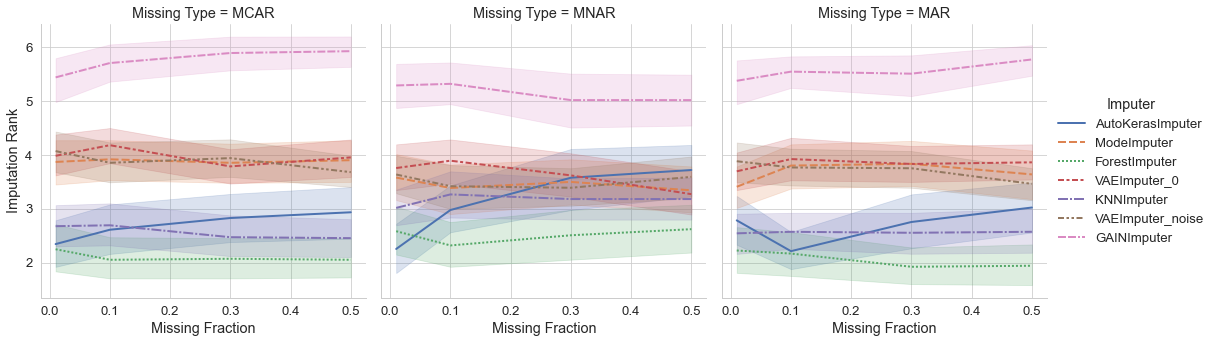

In [24]:
row_idx = (results["result_type"] == IMPUTE_RESULT_TYPE) & (results["metric"].isin([CLF_METRIC, REG_METRIC]))
plot_data = impute_results[row_idx]

sns.relplot(
    data=plot_data, 
    x="Missing Fraction", 
    y="Imputation Rank", 
    hue="Imputer", 
    style="Imputer", 
    col="Missing Type",
    kind="line",
)
plt.gcf().subplots_adjust(bottom=0.15, left=0.05) # avoid x/ylabel cutoff in SVG export
plt.savefig(FIGURES_PATH/IMPUTE_RESULT_TYPE/"relplot.svg")